In [7]:
%load_ext autoreload
%autoreload 2

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from drift_ml.datasets.bosch_cnc_machining.utils.utils import augment_xyz_samples
from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import RawBoschCNCDataloader, STFTBoschCNCDataloader, NPYBoschCNCDataLoader

In [2]:
base_loader = NPYBoschCNCDataLoader(metadata_path="/home/nicolasj92/projects/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/metadata_ws4096.pkl")
base_loader.load_data(
    sample_data_x_path="/home/nicolasj92/projects/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_x_raw_ws4096.npy",
    sample_data_y_path="/home/nicolasj92/projects/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_y_raw_ws4096.npy"
    )
base_loader.generate_datasets_by_size(train_size=.5,val_size=.1,test_size=.4)

In [3]:
stft_base_loader = base_loader.get_windowed_samples_as_stft_dataloader(transform_fn=lambda x: x)

  0%|          | 0/42978 [00:00<?, ?it/s]

In [4]:
channel_means = np.mean(stft_base_loader.X_train, axis=(0, 2, 3), keepdims=True)
channel_stds = np.std(stft_base_loader.X_train, axis=(0, 2, 3), keepdims=True)

X_train_scaled = (stft_base_loader.X_train - channel_means) / channel_stds
X_val_scaled = (stft_base_loader.X_val - channel_means) / channel_stds
X_test_scaled = (stft_base_loader.X_test - channel_means) / channel_stds

In [8]:
import torch
from torch import tensor
from torchmetrics.classification import (
    BinaryAUROC,
    BinaryF1Score,
    BinaryAveragePrecision)
from drift_ml.datasets.bosch_cnc_machining.models.nnclassifier import NNClassifier
from drift_ml.datasets.bosch_cnc_machining.models.lenet import LeNet

torch.manual_seed(1)
np.random.seed(0)

auroc = BinaryAUROC()
auprc = BinaryAveragePrecision()
f1 = BinaryF1Score(threshold=0.5)

model = NNClassifier(model=LeNet)
model.fit(
    X_train_scaled, 
    stft_base_loader.y_train[:, np.newaxis], 
    X_val_scaled, 
    stft_base_loader.y_val[:, np.newaxis], 
    lrate=1e-2,
    epochs=20
)

DEBUG:root:Starting training with batch size 64, lrate 0.01, epochs 20


KeyboardInterrupt: 

In [17]:
y, y_scores = model.predict(X_test_scaled, return_scores=True)
y_test = tensor(stft_base_loader.y_test[:, np.newaxis])

auroc_score = auroc(y_scores, y_test)
auprc_score = auprc(y_scores, y_test)
f1_score = f1(y_scores, y_test)

print(f"Test AUROC: {auroc_score:.3f}, AUPRC: {auprc_score:.3f}, F1: {f1_score:.3f}")

: 

: 

In [8]:
stft_loader = base_loader.get_windowed_samples_as_stft_dataloader(
    transform_fn=lambda x: augment_xyz_samples(x, yaw_deg=150, roll_deg=150)
)
X_test_scaled = (stft_loader.X_test - channel_means) / channel_stds

  0%|          | 0/42978 [00:00<?, ?it/s]

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/nicolasj92/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/nicolasj92/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/nicolasj92/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_m

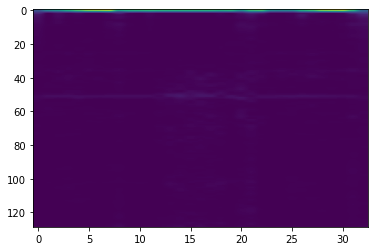

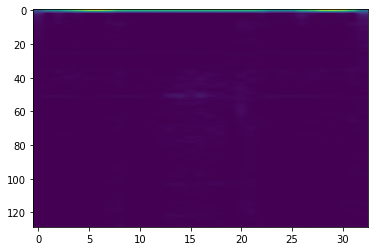

False


In [9]:
image = 212
channel = 2

plt.imshow(X_test_scaled[image, channel], aspect="auto")
plt.show()
X_base_test_scaled = (stft_base_loader.X_test - channel_means) / channel_stds
plt.imshow(X_base_test_scaled[image, channel], aspect="auto")
plt.show()

print(np.all(np.isclose(X_test_scaled[image, channel], X_base_test_scaled[image, channel])))

In [10]:
y, y_scores = model.predict(X_test_scaled, return_scores=True)
y_test = tensor(stft_loader.y_test[:, np.newaxis])

auroc_score = auroc(y_scores, y_test)
auprc_score = auprc(y_scores, y_test)
f1_score = f1(y_scores, y_test)

print(f"Test AUROC: {auroc_score:.3f}, AUPRC: {auprc_score:.3f}, F1: {f1_score:.3f}")

Test AUROC: 1.000, AUPRC: 1.000, F1: 1.000


In [13]:
y_scores[y_test == 0]

tensor([6.0310e-03, 3.4830e-04, 2.0605e-04, 7.9695e-04, 2.8667e-04, 2.0391e-04,
        2.2455e-04, 2.6820e-04, 1.2443e-03, 1.9141e-04, 5.4113e-04, 6.5311e-03,
        5.7970e-03, 6.9886e-05, 1.9621e-04, 2.6544e-04, 1.6842e-04, 2.3887e-04,
        2.5533e-04, 1.0625e-04, 7.5235e-04, 1.9424e-04, 3.6173e-04, 4.6873e-03,
        5.1806e-03, 1.3251e-03, 4.0781e-04, 4.4835e-04, 2.6597e-04, 5.6985e-04,
        4.1186e-04, 2.8323e-04, 2.7913e-03, 4.1297e-04, 4.8774e-04, 5.3534e-03,
        4.4726e-03, 7.5419e-04, 2.9332e-04, 5.9976e-04, 4.7157e-04, 3.8135e-04,
        4.7988e-04, 4.3073e-04, 2.1947e-03, 3.7038e-04, 5.1279e-04, 4.7859e-03,
        8.8685e-03, 1.6831e-06, 1.3477e-05, 1.4377e-04, 1.9769e-05, 6.4057e-05,
        3.0452e-05, 4.9431e-05, 1.6236e-05, 9.6539e-06, 1.3937e-03, 4.7152e-03,
        1.3396e-04, 2.0991e-04, 2.6448e-04, 1.5506e-04, 1.7765e-04, 1.9692e-04,
        1.3985e-04, 1.1389e-03, 2.4411e-04, 1.2038e-04, 4.8306e-03, 4.5227e-03,
        9.4155e-04, 1.9867e-04, 4.5118e-